## Comparing demographic models in an *Enterovirus* data set

In this example we compare the constant-size coalescent (CSC) and the exponential growth (EGC) model for an *Enterovirus* data set under the strict clock. We conducted ten cross-validation replicates using 50% of the data as training and test set. 

- The first step is to fetch the names of the test data files in this directory:

In [59]:
test_data_files <- dir(pattern ='enterovir_test.+fasta')
test_data_files

[1] "enterovir_test_1.fasta"  "enterovir_test_10.fasta"
 [3] "enterovir_test_2.fasta"  "enterovir_test_3.fasta" 
 [5] "enterovir_test_4.fasta"  "enterovir_test_5.fasta" 
 [7] "enterovir_test_6.fasta"  "enterovir_test_7.fasta" 
 [9] "enterovir_test_8.fasta"  "enterovir_test_9.fasta"

- The likelihoods will be computed using the P4 Python package. But we will run P4 through the terminal and import the results into R. To do this, we need a function to capture the P4 output and convert it into numeric values that we can use later. The R funcion below has some regular expressions to handle the P4 output:

In [51]:
capture_likelihood <- function(x){
    str_liks <- grep('^Tree', x, value = T)
    num_liks <- as.numeric(gsub('[A-Z]|[a-z]|[(]|[a-z][.][a-z]|[)][.]', '', str_liks))
    return(num_liks)
}

- In the cell below we make a matrix with two columns, one for each of the models (CSC and EGC). The rows correspond to a cross-validation replicate. We use the names of the files above to make the input names of BEAST2 log files and phylograms. We use these as input for a P4 script calleed *cv_p_likelihoods.py* in the *scripts* folder in this repository. We run the P4 script using *system*, which runs terminal commands through R.

In [60]:
model_likelihoods <- matrix(NA, 10, 2)
colnames(model_likelihoods) <- c('SC_CSC', 'SC_EGC')

for(i in 1:length(test_data_files)){
    temp_1 <- gsub('test', 'training', test_data_files[i])
    cat('Analysing cross-validation replicate', i, '\n')
    # Use grep to specify strict clock constant size input files and calculate likelihoods
    log_sc <- gsub('.fasta', '_strict_constant.log', temp_1)
    phylogs_sc <- gsub('.fasta', '_strict_constant_phylogs.trees', temp_1)
    x <- system(paste('python ../scripts/cv_p4_likelihoods.py', test_data_files[i], log_sc, 
             phylogs_sc), intern = T)
    
    model_likelihoods[i, 'SC_CSC'] <- mean(capture_likelihood(x))
    
    # Same as above for the SC+EGC model. Note that the test and traing 
    #set is the same but we use a different posterior run
    log_se <- gsub('.fasta', '_strict_exponential.log', temp_1)
    phylogs_se <- gsub('.fasta', '_strict_exponential_phylogs.trees', temp_1)
    x <- system(paste('python ../scripts/cv_p4_likelihoods.py', test_data_files[i], log_se, 
             phylogs_se), intern = T)
    
    model_likelihoods[i, 'SC_EGC'] <- mean(capture_likelihood(x))
    
}

Analysing cross-validation replicate 1 
Analysing cross-validation replicate 2 
Analysing cross-validation replicate 3 
Analysing cross-validation replicate 4 
Analysing cross-validation replicate 5 
Analysing cross-validation replicate 6 
Analysing cross-validation replicate 7 
Analysing cross-validation replicate 8 
Analysing cross-validation replicate 9 
Analysing cross-validation replicate 10 


- The matrix *model_likelihoods* contains the mean likelihood of the test set under the posterior of each of the training sets. 

In [63]:
model_likelihoods

SC_CSC,SC_EGC
-1146.990,-1134.049
-1082.970,-1078.586
-1185.409,-1174.723
-1111.281,-1111.598
-1087.105,-1074.613
-1094.480,-1087.171
-1100.467,-1094.787
-1174.443,-1173.751
-1238.835,-1213.014
-1072.361,-1080.401


- Overall, it seems that the right-hand column has higher likelihoods. To select the best model, we take the average:

In [64]:
colMeans(model_likelihoods)

SC_CSC    SC_EGC 
-1129.434 -1122.269

- This suggests that the EGC is a better fit to these data. To confirm this, we can have a quick look at the growth rate estimated for one of the trainig sets:

In [66]:
training_log_1 <- read.table('enterovir_training_1_strict_exponential.log', head = T)

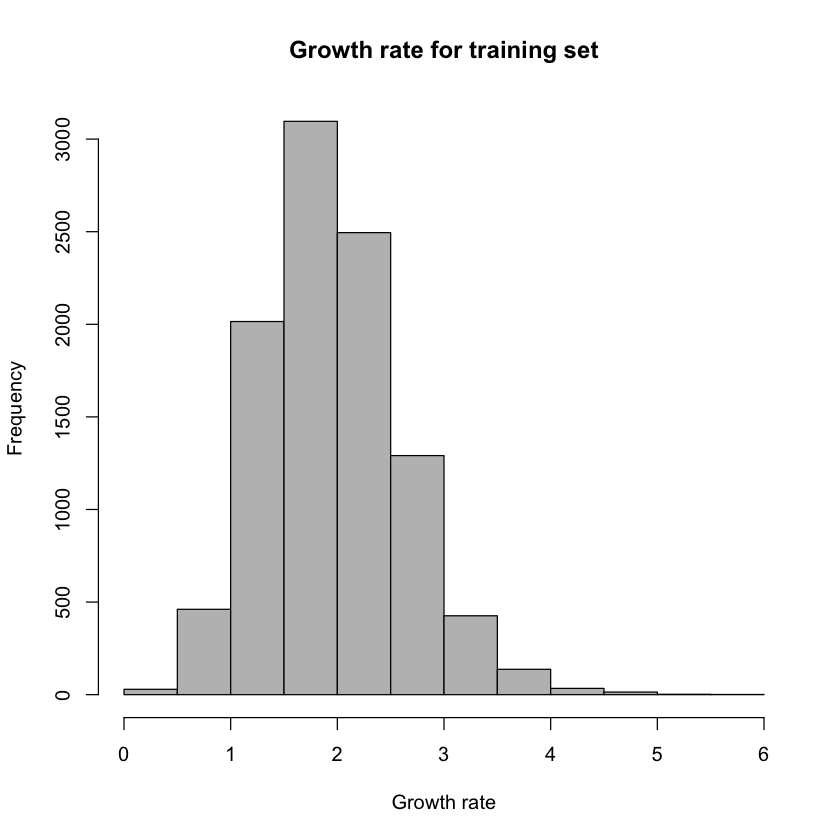

In [71]:
hist(training_log_1$growthRate, col = 'grey', main = 'Growth rate for training set',
    xlab = 'Growth rate')

- Note that the mode of the posterior is at around 2, and far from zero, which is consistent with a positive population growth. Moreover, the 95% creidble interval does not include 0, as shown below. In practice, a formal inspection of this parameter sholud be done using the whole data set, as done in the original study.

In [72]:
quantile(training_log_1$growthRate, c(0.025, 0.975))

2.5%     97.5% 
0.8467782 3.3842529